# Building Unsupervised KMeans Model for Clustering Palmer Penguins Dataset

## 1. Import libraries and datasets

In [ ]:
# install.packages("tidyverse")
# install.packages("rlang")
# install.packages("tidymodels")
# install.packages("palmerpenguins")
# install.packages("factoextra")

In [ ]:
# Load tidyverse, tidymodel, palmerpenguin 
library(tidyverse)
library(tidymodels)
library(factoextra)
library(palmerpenguins)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.3     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.1.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.4     ✔ yardstick    1.1.0
✔ recipes      1.0.5     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recip

## 2. EDA
Dataset contains true label (species), 2 factor (categorical) variables, and 5 numeric variables (2 double and 3 integer precision). 

In [ ]:
dim(penguins)
head(penguins,3)

[1] 344   8

species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
<fct>,<fct>,<dbl>,<dbl>,<int>,<int>,<fct>,<int>
Adelie,Torgersen,39.1,18.7,181,3750,male,2007
Adelie,Torgersen,39.5,17.4,186,3800,female,2007
Adelie,Torgersen,40.3,18.0,195,3250,female,2007


In [ ]:
# count penguin species
penguins %>% count(species)

species,n
<fct>,<int>
Adelie,152
Chinstrap,68
Gentoo,124


In [ ]:
# calc means
penguins %>% 
  group_by(species) %>% 
  summarize(across(where(is.numeric), mean, na.rm = TRUE))

Warning message:
“There was 1 warning in `summarize()`.
ℹ In argument: `across(where(is.numeric), mean, na.rm = TRUE)`.
ℹ In group 1: `species = Adelie`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))”


species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Adelie,38.79139,18.34636,189.9536,3700.662,2008.013
Chinstrap,48.83382,18.42059,195.8235,3733.088,2007.971
Gentoo,47.50488,14.98211,217.1870,5076.016,2008.081


In [ ]:
colnames(penguins)
glimpse(penguins)
# str(penguins)

[1] "species"           "island"            "bill_length_mm"   
[4] "bill_depth_mm"     "flipper_length_mm" "body_mass_g"      
[7] "sex"               "year"

Rows: 344
Columns: 8
$ species           <fct> Adelie, Adelie, Adelie, Adelie, Adelie, Adelie, Adel…
$ island            <fct> Torgersen, Torgersen, Torgersen, Torgersen, Torgerse…
$ bill_length_mm    <dbl> 39.1, 39.5, 40.3, NA, 36.7, 39.3, 38.9, 39.2, 34.1, …
$ bill_depth_mm     <dbl> 18.7, 17.4, 18.0, NA, 19.3, 20.6, 17.8, 19.6, 18.1, …
$ flipper_length_mm <int> 181, 186, 195, NA, 193, 190, 181, 195, 193, 190, 186…
$ body_mass_g       <int> 3750, 3800, 3250, NA, 3450, 3650, 3625, 4675, 3475, …
$ sex               <fct> male, female, female, NA, female, male, female, male…
$ year              <int> 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007…


In [ ]:
# check na's
penguins %>% map(~sum(is.na(.)))

$species
[1] 0

$island
[1] 0

$bill_length_mm
[1] 2

$bill_depth_mm
[1] 2

$flipper_length_mm
[1] 2

$body_mass_g
[1] 2

$sex
[1] 11

$year
[1] 0

In [ ]:
# calc means and replace na by means value
num_means <- penguins %>% 
  summarize(across(where(is.numeric), mean, na.rm = TRUE))
 
num_means$flipper_length_mm <- as.integer(round(num_means$flipper_length_mm))
num_means$body_mass_g <- as.integer(round(num_means$body_mass_g))

num_means

bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
<dbl>,<dbl>,<int>,<int>,<dbl>
43.92193,17.15117,201,4202,2008.029


In [ ]:
X <- penguins %>%
  select('bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g','year','sex','island') %>%
  replace_na(list(bill_length_mm = num_means$bill_length_mm,
                  bill_depth_mm = num_means$bill_depth_mm,
                  flipper_length_mm = num_means$flipper_length_mm,
                  body_mass_g = num_means$body_mass_g))
dim(X)

[1] 344   7

In [ ]:
# onehot encode sex col
X <- X %>% 
  mutate(dummy=1) %>%
  spread(key=sex, value=dummy, fill=0)
  
dim(X)
# X$island <- recode(X$island, Biscoe = 1, Dream = 2, Torgersen = 3)
# X$sex <- as.factor(X$sex) %>% fct_explicit_na(.,'0')

[1] 344   9

In [ ]:
# onehot encode island col
X <- X %>% mutate(dummy=1) %>% 
  spread(key=island, value=dummy, fill=0)

dim(X) # interestingly, after onehot encoding of island col, one row will be missing (dim=343x11) if year isn't included as feature? Not the case for sex col.

[1] 344  11

In [ ]:
# drop missing values
X$`<NA>` <- NULL

In [ ]:
glimpse(X)
X %>% map(~sum(is.na(.)))

Rows: 344
Columns: 10
$ bill_length_mm    <dbl> 32.1, 33.1, 33.5, 34.0, 34.1, 34.4, 34.5, 34.6, 34.6…
$ bill_depth_mm     <dbl> 15.5, 16.1, 19.0, 17.1, 18.1, 18.4, 18.1, 17.2, 21.1…
$ flipper_length_mm <int> 188, 178, 190, 185, 193, 184, 187, 189, 198, 190, 19…
$ body_mass_g       <int> 3050, 2900, 3600, 3400, 3475, 3325, 2900, 3200, 4400…
$ year              <int> 2009, 2008, 2008, 2008, 2007, 2007, 2008, 2008, 2007…
$ female            <dbl> 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1…
$ male              <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0…
$ Biscoe            <dbl> 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1…
$ Dream             <dbl> 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0…
$ Torgersen         <dbl> 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0…


$bill_length_mm
[1] 0

$bill_depth_mm
[1] 0

$flipper_length_mm
[1] 0

$body_mass_g
[1] 0

$year
[1] 0

$female
[1] 0

$male
[1] 0

$Biscoe
[1] 0

$Dream
[1] 0

$Torgersen
[1] 0

In [ ]:
X_scaled <- scale(X)

# 3. Train K-Means Unsupervised Learning Model

In [ ]:
set.seed=54321
km_out <- kmeans(X_scaled, center=3, nstart=50)
km_out

K-means clustering with 3 clusters of sizes 124, 111, 109

Cluster means:
  bill_length_mm bill_depth_mm flipper_length_mm body_mass_g        year
1     0.65288141     -1.092704         1.1512122    1.084539  0.06302318
2    -0.70308340      0.238011        -0.8582203   -0.981273 -0.04653083
3    -0.02674346      1.000698        -0.4356684   -0.234510 -0.02431149
       female         male     Biscoe      Dream  Torgersen
1 -0.02380353  0.007118341  1.0220439 -0.7496652 -0.4213840
2  0.96801869 -0.975587317 -0.5796604  0.4119782  0.2566851
3 -0.95870125  0.985390073 -0.5723957  0.4332927  0.2179778

Clustering vector:
  [1] 2 2 2 2 2 2 2 2 3 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2
 [38] 2 2 2 2 2 3 3 2 2 3 3 2 2 3 2 2 3 3 2 2 3 2 3 2 2 2 2 2 2 3 3 3 2 2 2 3 2
 [75] 3 2 3 2 2 2 2 3 3 3 3 3 3 2 2 2 2 2 3 3 2 2 3 3 3 3 3 2 2 3 2 3 2 3 3 3 3
[112] 3 3 3 3 1 2 2 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 1 3 1 3 3 3 2 3 3 2 2 2 3 1
[149] 1 3 1 3 1 3 3 1 2 3 3 1 1 1 1 1 2 1 1 3 1 1 3 3 

In [ ]:
length(km_out$cluster)
km_out$center

[1] 344

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year,female,male,Biscoe,Dream,Torgersen
1,0.65288141,-1.092704,1.1512122,1.084539,0.06302318,-0.02380353,0.007118341,1.0220439,-0.7496652,-0.4213840
2,-0.70308340,0.238011,-0.8582203,-0.981273,-0.04653083,0.96801869,-0.975587317,-0.5796604,0.4119782,0.2566851
3,-0.02674346,1.000698,-0.4356684,-0.234510,-0.02431149,-0.95870125,0.985390073,-0.5723957,0.4332927,0.2179778


In [ ]:
length(penguins$species)

[1] 344

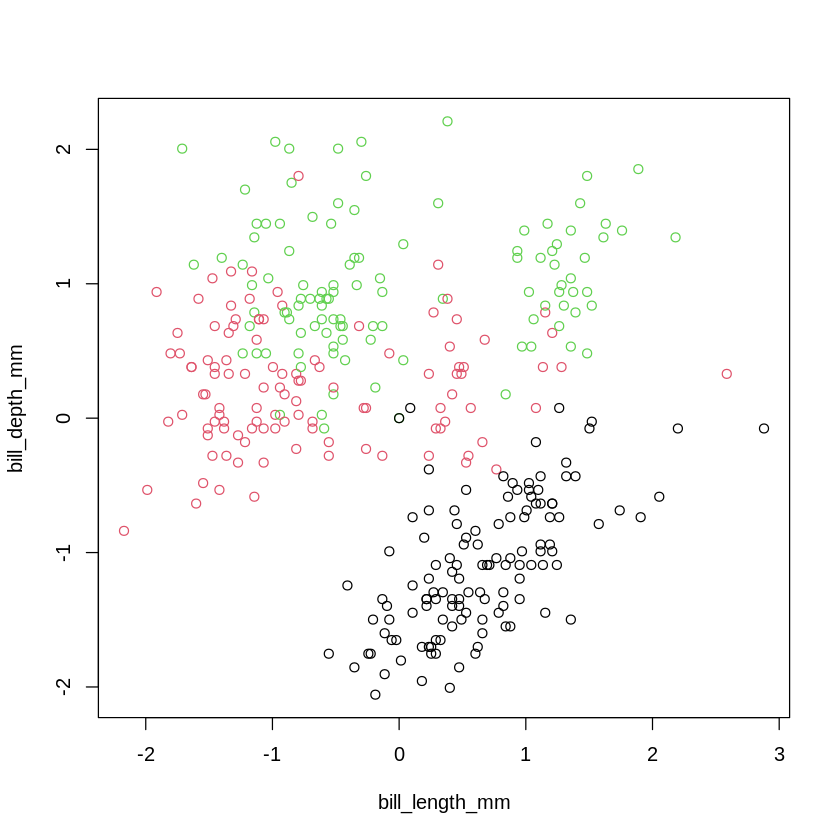

In [ ]:
plot(X_scaled,col=km_out$cluster)

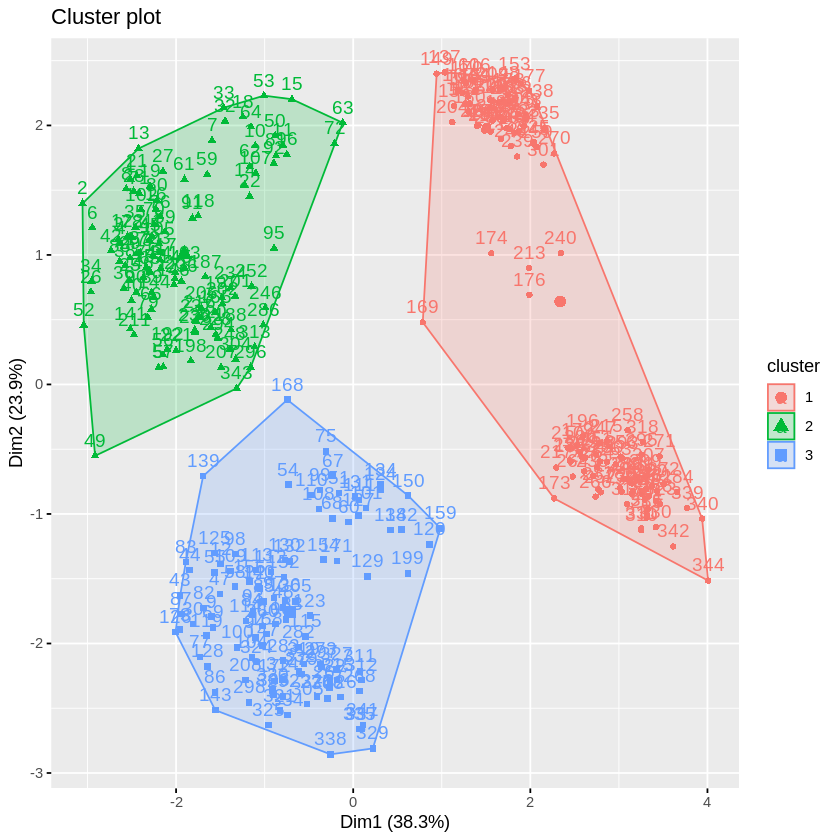

In [ ]:
# Visualize cluster on PCA-reduced 2D features
fviz_cluster(list(data=X,cluster=km_out$cluster))

In [ ]:
table(km_out$cluster,penguins$species)
# given the true label of penguin species, prediction accuracy can still be improved despite relatively good cluster separation

   
    Adelie Chinstrap Gentoo
  1      6        33     85
  2     81         6     24
  3     65        29     15

# 4. References:
1. https://cran.r-project.org/web/packages/palmerpenguins/readme/README.html
2. https://www.youtube.com/watch?v=NKQpVU1LTm8
3. https://www.youtube.com/watch?v=GZj6ikx8PAc

In [ ]:
penguins$year

[1] 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007
 [16] 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007
 [31] 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007
 [46] 2007 2007 2007 2007 2007 2008 2008 2008 2008 2008 2008 2008 2008 2008 2008
 [61] 2008 2008 2008 2008 2008 2008 2008 2008 2008 2008 2008 2008 2008 2008 2008
 [76] 2008 2008 2008 2008 2008 2008 2008 2008 2008 2008 2008 2008 2008 2008 2008
 [91] 2008 2008 2008 2008 2008 2008 2008 2008 2008 2008 2009 2009 2009 2009 2009
[106] 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009
[121] 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009
[136] 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009
[151] 2009 2009 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007
[166] 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007
[181] 2007 2007 2007 2007 2007 2007 2008 2008 2008 2008 2008 2008 2008 2008 2008
[196] 2008 2008 2008 2008 2008 2008 2008 2008 2008 2008 2008 2008 2008 2008 2008
[211] 2008 2008 2008 2008 2008 2008 2008 2008 2008 2008 2008 2008 2008 2008 2008
[226] 2008 2008 2008 2008 2008 2008 2008 2009 2009 2009 2009 2009 2009 2009 2009
[241] 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009
[256] 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009
[271] 2009 2009 2009 2009 2009 2009 2007 2007 2007 2007 2007 2007 2007 2007 2007
[286] 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007 2007
[301] 2007 2007 2008 2008 2008 2008 2008 2008 2008 2008 2008 2008 2008 2008 2008
[316] 2008 2008 2008 2008 2008 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009
[331] 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009

In [ ]:
penguins$island

[1] Torgersen Torgersen Torgersen Torgersen Torgersen Torgersen Torgersen
  [8] Torgersen Torgersen Torgersen Torgersen Torgersen Torgersen Torgersen
 [15] Torgersen Torgersen Torgersen Torgersen Torgersen Torgersen Biscoe   
 [22] Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe   
 [29] Biscoe    Biscoe    Dream     Dream     Dream     Dream     Dream    
 [36] Dream     Dream     Dream     Dream     Dream     Dream     Dream    
 [43] Dream     Dream     Dream     Dream     Dream     Dream     Dream    
 [50] Dream     Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe   
 [57] Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe   
 [64] Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Torgersen Torgersen
 [71] Torgersen Torgersen Torgersen Torgersen Torgersen Torgersen Torgersen
 [78] Torgersen Torgersen Torgersen Torgersen Torgersen Torgersen Torgersen
 [85] Dream     Dream     Dream     Dream     Dream     Dream     Dream    
 [92] Dream     Dream     Dream     Dream     Dream     Dream     Dream    
 [99] Dream     Dream     Biscoe    Biscoe    Biscoe    Biscoe    Biscoe   
[106] Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe   
[113] Biscoe    Biscoe    Biscoe    Biscoe    Torgersen Torgersen Torgersen
[120] Torgersen Torgersen Torgersen Torgersen Torgersen Torgersen Torgersen
[127] Torgersen Torgersen Torgersen Torgersen Torgersen Torgersen Dream    
[134] Dream     Dream     Dream     Dream     Dream     Dream     Dream    
[141] Dream     Dream     Dream     Dream     Dream     Dream     Dream    
[148] Dream     Dream     Dream     Dream     Dream     Biscoe    Biscoe   
[155] Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe   
[162] Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe   
[169] Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe   
[176] Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe   
[183] Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe   
[190] Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe   
[197] Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe   
[204] Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe   
[211] Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe   
[218] Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe   
[225] Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe   
[232] Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe   
[239] Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe   
[246] Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe   
[253] Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe   
[260] Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe   
[267] Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe    Biscoe   
[274] Biscoe    Biscoe    Biscoe    Dream     Dream     Dream     Dream    
[281] Dream     Dream     Dream     Dream     Dream     Dream     Dream    
[288] Dream     Dream     Dream     Dream     Dream     Dream     Dream    
[295] Dream     Dream     Dream     Dream     Dream     Dream     Dream    
[302] Dream     Dream     Dream     Dream     Dream     Dream     Dream    
[309] Dream     Dream     Dream     Dream     Dream     Dream     Dream    
[316] Dream     Dream     Dream     Dream     Dream     Dream     Dream    
[323] Dream     Dream     Dream     Dream     Dream     Dream     Dream    
[330] Dream     Dream     Dream     Dream     Dream     Dream     Dream    
[337] Dream     Dream     Dream     Dream     Dream     Dream     Dream    
[344] Dream    
Levels: Biscoe Dream Torgersen

In [ ]:
penguins$sex

[1] male   female female <NA>   female male   female male   <NA>   <NA>  
 [11] <NA>   <NA>   female male   male   female female male   female male  
 [21] female male   female male   male   female male   female female male  
 [31] female male   female male   female male   male   female female male  
 [41] female male   female male   female male   male   <NA>   female male  
 [51] female male   female male   female male   female male   female male  
 [61] female male   female male   female male   female male   female male  
 [71] female male   female male   female male   female male   female male  
 [81] female male   female male   female male   male   female male   female
 [91] female male   female male   female male   female male   female male  
[101] female male   female male   female male   female male   female male  
[111] female male   female male   female male   female male   female male  
[121] female male   female male   female male   female male   female male  
[131] female male   female male   female male   female male   female male  
[141] female male   female male   female male   male   female female male  
[151] female male   female male   female male   male   female female male  
[161] female male   female male   female male   female male   female male  
[171] female male   male   female female male   female male   <NA>   male  
[181] female male   male   female female male   female male   female male  
[191] female male   female male   female male   male   female female male  
[201] female male   female male   female male   female male   female male  
[211] female male   female male   female male   female male   <NA>   male  
[221] female male   female male   male   female female male   female male  
[231] female male   female male   female male   female male   female male  
[241] female male   female male   female male   female male   male   female
[251] female male   female male   female male   <NA>   male   female male  
[261] female male   female male   female male   female male   <NA>   male  
[271] female <NA>   female male   female male   female male   male   female
[281] male   female female male   female male   female male   female male  
[291] female male   male   female female male   female male   female male  
[301] female male   female male   female male   female male   female male  
[311] male   female female male   female male   male   female male   female
[321] female male   female male   male   female female male   female male  
[331] female male   female male   male   female male   female female male  
[341] female male   male   female
Levels: female male